In [1]:
# 下载和缓存数据集
import hashlib
import os
import tarfile
import zipfile
import requests

#@save
DATA_HUB = dict()
DATA_URL = 'http://d2l-data.s3-accelerate.amazonaws.com/'

下⾯的download函数⽤来下载数据集，将数据集缓存在本地⽬录（默认情况下为../data）中，并返回下
载⽂件的名称。如果缓存⽬录中已经存在此数据集⽂件，并且其sha-1与存储在DATA_HUB中的相匹配，我们
将使⽤缓存的⽂件，以避免重复的下载。

In [2]:
def download(name, cache_dir=os.path.join('..', 'data')): #@save
    """下载⼀个DATA_HUB中的⽂件，返回本地⽂件名"""
    assert name in DATA_HUB, f"{name} 不存在于 {DATA_HUB}"
    url, sha1_hash = DATA_HUB[name]
    os.makedirs(cache_dir, exist_ok=True)
    fname = os.path.join(cache_dir, url.split('/')[-1])
    if os.path.exists(fname):
        sha1 = hashlib.sha1()
        with open(fname, 'rb') as f:
            while True:
                data = f.read(1048576)
                if not data:
                    break
                sha1.update(data)
        if sha1.hexdigest() == sha1_hash:
            return fname # 命中缓存
    print(f'正在从{url}下载{fname}...')
    r = requests.get(url, stream=True, verify=True)
    with open(fname, 'wb') as f:
        f.write(r.content)
    return fname

我们还需实现两个实⽤函数：⼀个将下载并解压缩⼀个zip或tar⽂件，另⼀个是将本书中使⽤的所有数据集从DATA_HUB下载到缓存⽬录中。


In [3]:
def download_extract(name, folder=None): #@save
    """下载并解压zip/tar⽂件"""
    fname = download(name)
    base_dir = os.path.dirname(fname)
    data_dir, ext = os.path.splitext(fname)
    if ext == '.zip':
        fp = zipfile.ZipFile(fname, 'r')
    elif ext in ('.tar', '.gz'):
        fp = tarfile.open(fname, 'r')
    else:
        assert False, '只有zip/tar⽂件可以被解压缩'
    fp.extractall(base_dir)
    return os.path.join(base_dir, folder) if folder else data_dir

def download_all(): #@save
    # """下载DATA_HUB中的所有⽂件"""
    for name in DATA_HUB:
        download(name)

## 访问和读取数据集

In [4]:
%matplotlib inline
import numpy as np
import pandas as pd
import torch
from torch import nn
from d2l import torch as d2l

为⽅便起⻅，我们可以使⽤上⾯定义的脚本下载并缓存Kaggle房屋数据集。

In [5]:
DATA_HUB['kaggle_house_train'] = ( #@save
DATA_URL + 'kaggle_house_pred_train.csv',
'585e9cc93e70b39160e7921475f9bcd7d31219ce')
DATA_HUB['kaggle_house_test'] = ( #@save
DATA_URL + 'kaggle_house_pred_test.csv',
'fa19780a7b011d9b009e8bff8e99922a8ee2eb90')

我们使⽤pandas分别加载包含训练数据和测试数据的两个CSV⽂件。

In [28]:
train_data = pd.read_csv(download('kaggle_house_train'))
test_data = pd.read_csv(download('kaggle_house_test'))

训练数据集包括 1460 个样本，每个样本 80 个特征和 1 个标签，⽽测试数据集包含 1459 个样本，每个样本 80 个特征。


In [29]:
print(train_data.shape)
print(test_data.shape)
# train 有 ID 列，所以 shape 比 test 多一列，test 没有 ID 列

(1460, 81)
(1459, 80)


让我们看看前四个和最后两个特征，以及相应标签（房价）

In [30]:
print(train_data.iloc[0:4,[0, 1, 2, 3, -3, -2, -1]])
# 看看前四个样本，选择其前四个和U最后两个特征[0, 1, 2, 3, -3, -2] ，别忘了标签（房价）在最后一列，还有加一个 -1


   Id  MSSubClass MSZoning  LotFrontage SaleType SaleCondition  SalePrice
0   1          60       RL         65.0       WD        Normal     208500
1   2          20       RL         80.0       WD        Normal     181500
2   3          60       RL         68.0       WD        Normal     223500
3   4          70       RL         60.0       WD       Abnorml     140000


在每一个样本中，第一个特征是 ID，ID 不参与训练，我们将其从数据集中删除，这里还把最后一列的房价也丢弃了

In [31]:
all_features = pd.concat((train_data.iloc[:,1:-1], test_data.iloc[:, 1:]))
# iloc 左闭右开，这里直接合并所有的 feature 数据（即不包含最后一列（价格））
all_features.shape

(2919, 79)

我们有各种各样的数据类型，在开始建模之前，我们需要对数据进⾏预处理：将所有**缺失的值**替换为相应特征的平均值，为了**将所有特征放在⼀个共同的尺度上**，通过将特征重新缩放到零均值和单位房差来标准化数据

In [32]:
# 提取所有是数值的特征。（pandas 中的 object 是 Python 里面的 str）
# 这里先处理数值特征，稍后再处理文本特征
numeric_features = all_features.dtypes[all_features.dtypes != 'object'].index 
# 返回类型不为 object 列的列名，即返回所有为 数值类型 列的列名
numeric_features

Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold'],
      dtype='object')

In [33]:
all_features[numeric_features] = all_features[numeric_features].apply(
    lambda x: (x - x.mean()) / (x.std())) # 标准化数据
# pandas 的 apply() 函数可以作用于 Series 或者整个 DataFrame，功能也是自动遍历整个 Series 或者 DataFrame, 对每一个元素运行指定的函数
all_features[numeric_features] = all_features[numeric_features].fillna(0) # 将缺失值设置为 0 

我们处理离散值。这包括诸如“MSZoning”之类的特征。我们⽤独热编码替换它们，⽅法与前⾯
将多类别标签转换为向量的⽅式相同。例如，“MSZoning”包含值“RL”和“Rm”。我们将创建两个新的指⽰器特征“MSZoning_RL”和“MSZoning_RM”，其值为0或1。根据独热编码，如果
“MSZoning”的原始值为“RL”，则：“MSZoning_RL”为1，“MSZoning_RM”为0。pandas软件包会⾃动为我们实现这⼀点。


In [34]:
# 这里就是处理文本类型
# “Dummy_na=True”将“na”（缺失值）视为有效的特征值，并为其创建指⽰符特征
all_features = pd.get_dummies(all_features, dummy_na=True)
all_features.shape
# 此转换会将特征的总数量从79个增加到331个

(2919, 331)

最后，通过values属性，我们可以从pandas格式中提取NumPy格式，并将其转换为张量表⽰⽤于训练。

In [35]:
n_train = train_data.shape[0] # 训练样本数量
train_features = torch.tensor(all_features[:n_train].values, dtype=torch.float32)
test_features = torch.tensor(all_features[n_train:].values, dtype=torch.float32)
train_labels = torch.tensor(train_data.SalePrice.values.reshape(-1, 1), dtype=torch.float32)

## 训练
我们训练⼀个带有损失平⽅的线性模型。显然线性模型很难让我们在竞赛中获胜，但线性模型提供了
⼀种健全性检查，以查看数据中是否存在有意义的信息。如果我们在这⾥不能做得⽐随机猜测更好，那么我们很可能存在数据处理错误。如果⼀切顺利，线性模型将作为基线（baseline）模型，让我们直观地知道最好的模型有超出简单的模型多少。

In [36]:
loss = nn.MSELoss() # 均方损失函数
# train_features.shape --> torch.Size([1460, 331]) 1460 个样本，331 个特征
in_features = train_features.shape[1] # 获取输入特征

# 定义线性回归网络模型
def get_net():
    net = nn.Sequential(nn.Linear(in_features, 1)) # 使用单层线性回归
    return net

我们更关心相对误差 $\frac{y-\hat{y}}{y}$，解决这个问题的一种方法是用价格预测的对数来衡量差异

In [38]:
# 定义质量误差指标函数（使用对数）
def log_rmse(net, features, lables):
    # 为了在取对数是进一步稳定该值，将小于 1 的值设置为 1
    clipped_preds = torch.clamp(net(features), 1, float('inf')) 
    # clamp（）函数的功能将输入input张量每个元素的值压缩到区间 [min,max]，并返回结果到一个新张量。
    # torch.clamp(input, min, max, out=None) → Tensor
    # float('inf) 表示正无穷
    rmse = torch.sqrt(loss(torch.log(clipped_preds), torch.log(lables)))
    return rmse.item()
# 其实就是将预测的值做个 log，以及 Label 的值做个 log，然后按照正常线性回归的步骤来做
#  item()的作用是取出单元素张量的元素值并返回该值,保持该元素类型不变

In [52]:
# test
# a = torch.randint(0, 10, size=(10, 1))
# b = torch.clamp(a, 3, 4)
# b

训练函数借助 Adam 优化器，Adam优化器的主要吸引⼒在于它对初始学习率不那么敏感。（Adam 可以看做比较平滑的 SGD）

In [49]:
def train(net, train_features, train_labels, test_features, test_labels, num_epochs, learning_rate, weight_decay, batch_size):
    train_ls, test_ls = [], []
    train_iter = d2l.load_array((train_features, train_labels), batch_size)
    # 这里使用的是 Adam 优化算法
    optimizer = torch.optim.Adam(net.parameters(), lr = learning_rate, weight_decay = weight_decay)
    for epoch in range(num_epochs):
        for X, y in train_iter:
            optimizer.zero_grad()
            l = loss(net(X), y)
            l.backward()
            optimizer.step()
        train_ls.append(log_rmse(net, train_features, train_labels))
        if test_labels is not None:
            test_ls.append(log_rmse(net, test_features, test_labels))
    return train_ls, test_ls

### K 折交叉验证

我们在讨论模型选择的部分中介绍了K折交叉验证，它有助于模型选择和超参数调整。我们⾸先需要定义⼀个函数，在K折交叉验证过程中返回第i折的数据。具体地说，它选择第i个切⽚作为验证数据，其余部分作为训练数据。注意，这并不是处理数据的最有效⽅法，如果我们的数据集⼤得多，会有其他解决办法。


In [50]:
def get_k_fold_data(k, i, X, y):
    assert k > 1
    fold_size = X.shape[0] // k
    X_train, y_train = None, None
    for j in range(k):
        idx = slice(j * fold_size, (j + 1) * fold_size)
        X_part, y_part = X[idx, :], y[idx]
        if j == i:
            X_valid, y_valid = X_part, y_part
        elif X_train is None:
            X_train, y_train = X_part, y_part
        else:
            X_train = torch.cat([X_train, X_part], 0)
            y_train = torch.cat([y_train, y_part], 0)
    return X_train, y_train, X_valid, y_valid

返回训练和验证误差的平均值

In [51]:
def k_fold(k, X_train, y_train, num_epochs, learning_rate, weight_decay, batch_size):
    train_l_sum, valid_l_sum = 0, 0
    for i in range(k):
        data = get_k_fold_data(k, i, X_train, y_train)
        net = get_net()
        train_ls, valid_ls = train(net, *data, num_epochs, learning_rate, weight_decay, batch_size)
        train_l_sum += train_ls[-1]
        valid_l_sum += valid_ls[-1]
        if i == 0:
            d2l.plot(list(range(1, num_epochs + 1)), [train_ls, valid_ls],xlabel='epoch', ylabel='rmse', xlim=[1, num_epochs],legend=['train', 'valid'], yscale='log')
        print(f'折{i + 1}，训练log rmse{float(train_ls[-1]):f}, 'f'验证log rmse{float(valid_ls[-1]):f}')
        return train_l_sum / k, valid_l_sum / k

折1，训练log rmse0.169832, 验证log rmse0.156869
5-折验证: 平均训练log rmse: 0.033966, 平均验证log rmse: 0.031374


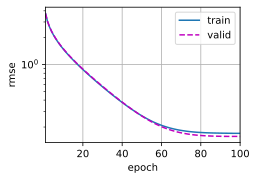

In [52]:
# 选择一组未调优的超参数，看看效果
k, num_epochs, lr, weight_decay, batch_size = 5, 100, 5, 0, 64
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr,weight_decay, batch_size)
print(f'{k}-折验证: 平均训练log rmse: {float(train_l):f}, 'f'平均验证log rmse: {float(valid_l):f}')